# How to write a training loop in Chainer

In this notebook session we will learn how to train a deep neural network to classify hand-written digits using the popular MNIST dataset. This dataset contains 50000 training examples and 10000 test examples. Each example contains a 28x28 greyscale image and a corresponding class label for the digit. Since the digits 0-9 are used, there are 10 class labels. 
 
Chainer provides a feature called `Trainer` that can be used to simplify the training process. However, we think it is good for first-time users to understand how the training process works before using the `Trainer` feature. Even advanced users might sometimes want to write their own training loop and so we will explain how to do so here. The complete training process consists of the following steps:

1. Prepare a datasets that contain the train/validation/test examples.
2. Optionally set of iterators for the datasets.
3. Write a training loop that performs the following operations in each iteration:
     1. Retreive batches of examples from the training dataset.
     2. Feed the batches into the model.
     3. Run the forward pass on the model to compute the loss.
     4. Run the backward pass on the model to compute the gradients.
     5. Run the optimizer on the model to update the parameters.
     6. (Optional): Ocassionally check the performance on a validation/test set.


In [2]:
# Install Chainer and CuPy!

!curl https://colab.chainer.org/install | sh -

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libcusparse8.0 is already the newest version (8.0.61-1).
libnvrtc8.0 is already the newest version (8.0.61-1).
libnvtoolsext1 is already the newest version (8.0.61-1).
0 upgraded, 0 newly installed, 0 to remove and 1 not upgraded.


## 1. Prepare the dataset

Chainer contains some built-in functions that can be used to download and return Chainer-formated versions of popular datasets used by the ML and deep learning communities. In this example, we will use the buil-in function that retreives the MNIST dataset.



/usr/local/lib/python3.6/dist-packages/cupy/core/fusion.py:659: FutureWarning: cupy.core.fusion is experimental. The interface can change in the future.
  util.experimental('cupy.core.fusion')


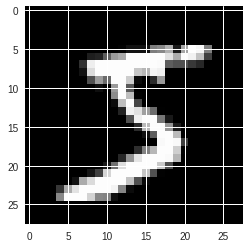

label: 5


In [3]:
from chainer.datasets import mnist

# Download the MNIST data if you haven't downloaded it yet
train, test = mnist.get_mnist(withlabel=True, ndim=1)

# set matplotlib so that we can see our drawing inside this notebook
%matplotlib inline
import matplotlib.pyplot as plt

# Display an example from the MNIST dataset.
# `x` contains the input image array and `t` contains that target class
# label as an integer.
x, t = train[0]
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.show()
print('label:', t)

## 2. Create the dataset iterators

Although this is an optional step, it can often be convenient to use iterators that operate on a dataset and return a certain number of examples (often called a "mini-batch") at a time. The number of examples that is returned at a time is called the "batch size" or "mini-batch size." Chainer already has an `Iterator` class and some subclasses that can be used for this purpose and it is straightforward for users to write their own as well.

We will use the `SerialIterator` subclass of `Iterator` in this example. The `SerialIterator` can either return the examples in the same order that they appear in the dataset (that is, in sequential order) or can shuffle the examples so that they are returned in a random order.

An Iterator can return a new minibatch by calling its 'next()' method. An Iterator also has properties to manage the training such as 'epoch': how many times we have gone through the entire dataset, 'is_new_epoch': whether the current iteration is the first iteration of a new epoch.

In [0]:
from chainer import iterators

# Choose the minibatch size.
batchsize = 128

train_iter = iterators.SerialIterator(train, batchsize)
test_iter = iterators.SerialIterator(test, batchsize,
                                     repeat=False, shuffle=False)

### Details about SerialIterator

- `SerialIterator` is a built-in subclass of `Iterator` that can be used to retrieve a dataset in either sequential or shuffled order.
- The `Iterator` initializer takes two arguments: the dataset object and a batch size. 
- When data need to be used repeatedly for training, set the 'repeat' argument to 'True' (the default). When data is needed only once and no longer necessary for retriving the data anymore, set 'repeat' to 'False'.
- When you want to shuffle the training dataset for every epoch, set the 'shuffle' argument 'True'.

In the example above, we set 'batchsize = 128', 'train_iter'is the Iterator for the training dataset, and 'test_iter' is the Iterator for test dataset. These iterators will therefore return 128 image examples as a bundle. 

## 3. Define the model

Now let's define a neural network that we will train to classify the MNIST images. For simplicity, we will use a fully-connected network with three layers. We will set each hidden layer to have 100 units and set the output layer to have 10 units, corresponding to the 10 class labels for the MNIST digits 0-9. 

We first briefly explain `Link`, `Function`, `Chain`, and `Variable` which are the basic components used for defining and running a model in Chainer. 

### `Link` and `Function`

In Chainer, each layer of a neural network is decomposed into one of two broad types of functions (actually, they are function objects): 'Link' and 'Function'.

- ** `Function` is a function without learnable parameters**
- ** `Link` is a function that contains (learnable) parameters** We can think of `Link` as wrapping a `Function` to give it parameters. That is, `Link` will contain the parameters and when it is called, it will also call a corresponding `Function`.

We then describe a model by implementing code the performs the "forward pass" computations. This code will call various links and chains (recall that `Link` and `Chain` are callable objects). Chainer will take care of the "backward pass" automatically and so we do not need to worry about that unless we want to write some custom functions.

- For examples of links, see the 'chainer.links' module.
- For examples of functions, see the 'chainer.functions' module.
- For example, see the `Linear` link, which wraps the `linear` function to give it weight and bias parameters.

Before we can start using them, we first need to import the modules as shown below.

    ```
    import chainer.links as L
    import chainer.functions as F
    ```
The Chainer convention is to use `L` for links and `F` for functions, like 'L.Convolution2D(...)' or 'F.relu(...)'.

### `Chain`

- `Chain` is a class that can hold multiple links and/or functions. It is a subclass of `Link` and so it is also a `Link`. 
- This means that a chain can contain parameters, which are the parameters of any links that it deeply contains.
- In this way, `Chain` allows us to construct models with a potentially deep hierarchy of functions and links.
- It is often convenient to use a single chain that contains all of the layers (other chains, links, and functions) of the model. This is because we will need to optimize the model's parameters during training and if all of the parameters are contained by a single chain, it turns out to be straightfoward to pass these parameters into an optimizer (which we describe in more detail below).

### `Variable`
In Chainer, both the activations (that is, the inputs and outputs of function and links) and the model parameters are instances of the `Variable` class. A `Variable` holds two arrays: a `data` array that contains the values that are read/written during the forward pass (or the parameter values), and a `grad` array that contains the corresponding gradients that will are computed during the backward pass.

A `Variable` can potentially contain two types of arrays as well, depending whether the array resides in CPU or GPU memory. By default, the CPU is used and these will be Numpy arrays. However, it is possible to move or create these arrays on the GPU as well, in which case they will be CuPy arrays. Fortunately, CuPy uses an API that is nearly identical to Numpy. This is convinient because in addition to making it easier for users to learn (there is almost nothing to learn if you are already familiar with Numpy), it often allows us to reuse the same code for both Numpy and CuPy arrays.


### Create our model as a subclass of 'Chain' 

We can create our model to write a new subclass of `Chain`. The two main steps are:

1. Any links (possibly also including other chains) that we wish to call during the forward computation of our chain must first be supplied to the chain's `__init__` method. After the `__init__` method has been called, these links will then be accessable as attributes of our chain object. This means that we also need to provide the attribute name that we want to use for each link that is supplied. We do this by providing the attribute name and corresponding link object as keyword arguments to `__init__`, as we will do in the `MLP` chain below.
2. We need to define a `__call__` method that allows our chain to be called like a function. This method takes one or more `Variable` objects as input (that is, the input activations) and returns one or more `Variable` objects. This method executes the forward pass of the model by calling any of the links that we supplied to `__init__` earlier as well as any functions.

Note that the links only need to be supplied to `__init__`, not `__call__`. This is because they contain parameters. Since functions do not contain any parameters, they can be called in `__call__` without having to supply them to the chain beforehand. For example, we can use a function such as `F.relu` by simply calling it in `__call__` but a link such as `L.Linear` would need to first be supplied to the chain's `__init__` in order to call it in `__call__`.

If we decide that we want to call a link in a chain after `__init__` has already been called, we can use the `add_link` method of `Chain` to add a new link at any time.

In Chainer, the Python code that implements the forward computation code itself represents the model. In other words, we can conceptually think of the computation graph for our model being constructed dynamically as this forward computation code executes. This allows Chainer to describe networks in which different computations can be performed in each iteration, such as branched networks, intuitively and with a high degree a flexibiity. This is the key feature of Chainer that we call **Define-by-Run**.


### How to run a model on GPU

- The `Link` and `Chain` classes have a `to_gpu` method that takes a GPU id argument specifying which GPU to use. This method sends all of the model parameters to GPU memory.
- By default, the CPU is used.


In [0]:
import chainer
import chainer.links as L
import chainer.functions as F

class MLP(chainer.Chain):

    def __init__(self, n_mid_units=100, n_out=10):
        # register layers with parameters by super initializer
        super(MLP, self).__init__()
        with self.init_scope():
            self.l1=L.Linear(None, n_mid_units)
            self.l2=L.Linear(None, n_mid_units)
            self.l3=L.Linear(None, n_out)

    def __call__(self, x):
        # describe the forward pass, given x (input data)
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)

gpu_id = 0  # change to -1 if not using GPU

model = MLP()
if gpu_id >= 0:
    model.to_gpu(gpu_id)

### NOTE

The `L.Linear` class is a link that represents a fully connected layer. When 'None' is passed as the first argument, this allows the number of necessary input units (`n_input`) and also the size of the weight and bias parameters to be automatically determined and computed at runtime during the first forward pass. We call this feature `parameter shape placeholder`. This can be a very helpful feature when defining deep neural network models, since it would often be tedious to manually determine these input sizes. 

As mentioned previously, a `Link` can contain multiple parameter arrays. For example, the `L.Linear` link conatins two parameter arrays: the weights `W` and bias `b`. Recall that for a given link or chain, such as the `MLP` chain above, the links it contains can be accessed as attributes (or properties). The parameters of a link can also be accessed as attributes. For example, following code shows how to access the bias parameter of layer l1:

In [6]:
print('The shape of the bias of the first layer, l1, in the model、', model.l1.b.shape)
print('The values of the bias of the first layer in the model after initialization、', model.l1.b.data)

The shape of the bias of the first layer, l1, in the model、 (100,)
The values of the bias of the first layer in the model after initialization、 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


## 4. Select an optimization algorithm

Chainer provides a wide variety of optimization algorithms that can be used to optimize the model parameters during training. They are located in the `chainer.optimizers` module. 

Here, we are going to use the basic stochastic gradient descent (SGD) method, which is implemented by `optimizers.SGD`. The model (recall that it is a `Chain` object) we created is passed to the optimizer object by providing the model as an argument to the optimizer's 'setup' method. In this way, Optimizer can automatically find the model parameters to be optimized. 

You can easily try out other optimizers as well. Please test and observe the results of various optimizers. For example, you could try to change 'SGD" of 'chainer.optimizers.SGD' to 'MomentumSGD', 'RMSprop', 'Adam', etc., and run your training loop. 

In [0]:
from chainer import optimizers

# Choose an optimizer algorithm
optimizer = optimizers.SGD(lr=0.01)
# Give the optimizer a reference to the model so that it
# can locate the model's parameters.
optimizer.setup(model)

### NOTE

Observe that above, we set`lr` to 0.01 in the SGD constructor. This value is known as a the "learning rate", one of the most important ** hyper parameters** that need be adjusted in order to obtain the best performance. The various optimizers may each have different hyper-parameters and so be sure to check the documentation for the details.

## 5. Write the training loop

We now show how to write the training loop. Since we are working on a digit classification problem, we will use `softmax_cross_entropy` as the loss function for the optimizer to minimize. For other types of problems, such as regression models, other loss functions might be more appropriate. See the Chainer documentation for detailed information on the various loss functions that are available.

Our training loop will be structured as follows. We will first get a mini-batch of examples from the training dataset. We will then feed the batch into our model by calling our model (a `Chain` object) like a function. This will execute the forward-pass code that we wrote for the chain's `__call__` method that we wrote above. This will cause the model to output class label predictions that we supply to the loss function along with the true (that is, target) values. The loss function will output the loss as a `Variable` object. We then clear any previous gradients and perform the backward pass by calling the `backward` method on the loss variable which computes the parameter gradients. We need to clear the gradients first because the `backward` method accumulates gradients instead of overwriting the previous values. Since the optimizer already was given a reference to the model, it already has access to the parameters and the newly-computed gradients and so we can now call the `update` method of the optimizer which will update the model parameters.

At this point you might be wondering how calling `backward` on the loss variable could possibly compute the gradients for all of the model parameters. This works as follows. First recall that all activation and parameter arrays in the model are instances of `Variable`. During the forward pass, as each function is called on its inputs, we save references in each output variable that refer to the function that created it and its input variables. In this way, by the time the final loss variable is computed, it actually contains backward references that lead all the way back to the input variables of the model. That is, the loss variable contains a representation of the entire computational graph of the model, which is recomputed each time the forward pass is performed. By following these backward references from the loss variable, each function as a `backward` method that gets called to compute any parameter gradients. Thus, by the time the end of the backward graph is reached (at the input variables of the model), all parameter gradients have been computed.  

Thus, there are four steps in single training loop iteration as shown below.

1. Obtain and pass a mini-batch of example images into the model and obtain the output digit predictions `prediction_train`. 
2. Compute the loss function, giving it the predicted labels from the output of our model and also the true "target" label values.
3. Clear any previous gradients and call the backward method of 'Variable' to compute the parameter gradients for the model.  
4. Call the 'update' method of Optimizer, which performs one optimization step and updates all of the model parameters.

In addition to the above steps, it is good to occasionally check the performance of our model on a validation and/or test set. This allows us to observe how well it can generalize to new data and also check whether it is overfitting. The code below checks the performance on the test set at the end of each epoch. The code has the same structure as the training code except that no backpropagation is performed and we also commpute the accuracy on the test set using the `F.accuracy` function.

We can write the training loop code as follows:

In [8]:
import numpy as np
from chainer.dataset import concat_examples
from chainer.cuda import to_cpu

max_epoch = 10

while train_iter.epoch < max_epoch:
    
    # ---------- The first iteration of training loop ----------
    train_batch = train_iter.next()
    image_train, target_train = concat_examples(train_batch, gpu_id)
    
    # calculate the prediction of the model
    prediction_train = model(image_train)

    # calculation of loss function, softmax_cross_entropy
    loss = F.softmax_cross_entropy(prediction_train, target_train)

    # calculate the gradients in the model
    model.cleargrads()
    loss.backward()

    # update the parameters of the model
    optimizer.update()
    # --------------- until here One loop ----------------
    
    # Check if the generalization of the model is improving 
    # by measuring the accuracy of prediction after every epoch

    if train_iter.is_new_epoch:  # after finishing the first epoch

        # display the result of the loss function
        print('epoch:{:02d} train_loss:{:.04f} '.format(
            train_iter.epoch, float(to_cpu(loss.data))), end='')

        test_losses = []
        test_accuracies = []
        for test_batch in test_iter:
            test_batch = test_iter.next()
            image_test, target_test = concat_examples(test_batch, gpu_id)

            # forward the test data
            prediction_test = model(image_test)

            # calculate the loss function
            loss_test = F.softmax_cross_entropy(prediction_test, target_test)
            test_losses.append(to_cpu(loss_test.data))

            # calculate the accuracy
            accuracy = F.accuracy(prediction_test, target_test)
            accuracy.to_cpu()
            test_accuracies.append(accuracy.data)

        test_iter.reset()

        print('val_loss:{:.04f} val_accuracy:{:.04f}'.format(
            np.mean(test_losses), np.mean(test_accuracies)))

epoch:01 train_loss:0.9583 val_loss:0.7864 val_accuracy:0.8211
epoch:02 train_loss:0.4803 val_loss:0.4501 val_accuracy:0.8812
epoch:03 train_loss:0.3057 val_loss:0.3667 val_accuracy:0.8982
epoch:04 train_loss:0.2477 val_loss:0.3292 val_accuracy:0.9054
epoch:05 train_loss:0.2172 val_loss:0.3059 val_accuracy:0.9133
epoch:06 train_loss:0.2202 val_loss:0.2880 val_accuracy:0.9176
epoch:07 train_loss:0.3009 val_loss:0.2758 val_accuracy:0.9214
epoch:08 train_loss:0.3399 val_loss:0.2632 val_accuracy:0.9252
epoch:09 train_loss:0.3497 val_loss:0.2538 val_accuracy:0.9287
epoch:10 train_loss:0.1691 val_loss:0.2430 val_accuracy:0.9311


## 6. Save the trained model

Chainer provides two types of serializers that can be used to save and restore model state. One supports the HDF5 format and the other supports the Numpy NPZ format. For this example, we are going to use the NPZ format to save our model since it is easy to use with Numpy without requiring an additional dependencies or libraries.

In [9]:
from chainer import serializers

serializers.save_npz('my_mnist.model', model)

# check if the model is saved.
%ls -la my_mnist.model

-rw-r--r-- 1 root root 333954 Feb 23 08:13 my_mnist.model


## 7. Perform classification by restoring a previously trained model 

We will now use our previously trained and saved MNIST model to classify a new image. In order to load a previously-trained model, we need to perform the following two steps:
1. We must use the same model definition code the was used to create the previously-trained model. For our example, this is the `MLP` chain that we created earlier.
2. We then overwrite any parameters in the newly-created model with the values that were saved earlier using the serializer. The `serializers.load_npz` function can be used to do this.

Now that the model has been restored, it can be used to predict image labels on new input images.

In [0]:
# Create the infrence (evaluation) model as the previous model
infer_model = MLP()

# Load the saved parameters into the parameters of the new inference model to overwrite 
serializers.load_npz('my_mnist.model', infer_model)

# Send the model to utilize GPU by to_GPU
if gpu_id >= 0:
    infer_model.to_gpu(gpu_id)

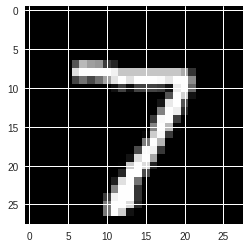

label: 7


In [11]:
# Get a test image and label
x, t = test[0]
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.show()
print('label:', t)

In [12]:
from chainer.cuda import to_gpu

# change the shape to minibutch. 
# In this example, the size of minibatch is 1. 
# Inference using any mini-batch size can be performed.

print(x.shape, end=' -> ')
x = x[None, ...]
print(x.shape)

# to calculate by GPU, send the data to GPU, too. 
if gpu_id >= 0:
    x = to_gpu(x, 0)

# forward calculation of the model by sending X
y = infer_model(x)

# The result is given as Variable, then we can take a look at the contents by the attribute, .data. 
y = y.data

# send the gpu result to cpu
y = to_cpu(y)

# The most probable number by looking at the argmax
pred_label = y.argmax(axis=1)

print('predicted label:', pred_label[0])

(784,) -> (1, 784)
predicted label: 7
